# 환경 준비

In [ ]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.3.*" "langchain-huggingface" "huggingface_hub" "sentence-transformers" wikipedia -q

In [ ]:
!pip install chromadb google-search-results -q

## 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain.chains import RetrievalQA
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

## API 확인

In [ ]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/langchain/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [ ]:
print(os.environ['HF_TOKEN'][:40])

# RAG1 : 간단한 RAG 구성하기

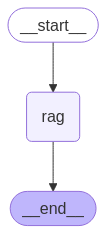

## state 정의

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Vector DB

OpenAI

In [ ]:
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
file_name = "sample.csv"
csv_loader = CSVLoader(file_path= path + file_name)
documents_csv = csv_loader.load()

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db")

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

Huggingface
- 한국어 특화 모델

In [ ]:
from langchain_community.document_loaders import CSVLoader
from langchain_huggingface import HuggingFaceEmbeddings # OpenAI 대신 사용
from langchain_community.vectorstores import Chroma

# 1. CSV 파일 로드
file_name = "sample.csv"
csv_loader = CSVLoader(file_path= path + file_name)
documents_csv = csv_loader.load()

# 2. 벡터 DB 정의 (HuggingFace 버전)
# 모델명 "jhgan/ko-sroberta-multitask"는 한국어 문장 임베딩에 널리 쓰이는 성능 좋은 모델입니다.
model_name = "jhgan/ko-sroberta-multitask"
model_kwargs = {'device': 'cpu'} # GPU 사용 시 'cuda'로 변경
encode_kwargs = {'normalize_embeddings': True} # 코사인 유사도 계산을 위해 정규화 권장

embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 3. Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents_csv,
    embedding,
    persist_directory= path + "chroma_db"
)

# 4. 리트리버 설정
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Hugging Face 임베딩 모델 (sentence-transformers 기반)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 3. Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents_csv,
    embedding,
    persist_directory= path + "chroma_db"
)

## Node 정의

* RAG 노드
    * 최근 사용자의 질문을 꺼내서
    * RAG 체인으로 답변을 얻고
    * 새로운 GPT 응답 메시지를 state["messages"]에 추가하는 역할

OpenAI

In [ ]:
# RAG Chain
llm = ChatOpenAI(model="gpt-4.1-mini")
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

HuggingFace

In [ ]:
# llm = ChatOpenAI(model="gpt-4.1-mini")  # 언어 모델을 gpt-4.1-mini로 설정
# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

In [ ]:
# RAG 노드 정의
def rag_node(state: State):
    # 메시지 리스트 중에서 HumanMessage (사용자 질문) 만 골라냄. m.content로 텍스트만 추출. [-1]: 가장 마지막 메시지를 선택
    user_msg = [m.content for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    answer = rag_chain.invoke({"query": user_msg})  # RetrievalQA 함수는 입력으로 {"query": user_msg} 형태를 요구
    return {"messages": [AIMessage(content=answer["result"])]}

## 그래프 정의

In [ ]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("rag", rag_node)

# connect nodes
builder.add_edge(START, "rag")
builder.add_edge("rag", END)

# compile the graph
graph = builder.compile()

In [ ]:
graph

## Graph 실행

In [ ]:
# LangGraph를 0.3대 대응 버전으로 업데이트 (현재 기준 최신 버전 설치)
!pip install -U "langchain>=0.3" "langchain-core>=0.3" "langchain-community>=0.3" "langgraph>=0.3" "langchain-huggingface" "huggingface_hub" "sentence-transformers" wikipedia -q

In [ ]:
result = graph.invoke({"messages": [HumanMessage(content="보안 위협 중 가장 중대한 것이 무엇인가요?")]})

for message in result["messages"]:
    message.pretty_print()

# RAG2 : VectorDB를 Tool로 사용하기

**구축절차**
1. Vector DB 준비 :  
2. Tool 정의 : Vector DB로 부터 검색하는 함수를 툴로 정의
3. LLM+Tool 바인딩
4. 노드 준비 & 분기 함수
5. 그래프 구성

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain.tools.render import render_text_description
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langgraph.prebuilt import ToolNode

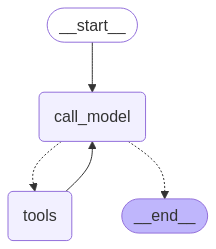

## Vector DB 준비

OpenAI

In [ ]:
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db01")

retriever = vector_db.as_retriever(search_kwargs={"k": 3})

HuggingFace
- 영어 특화 모델

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()
# Hugging Face 임베딩 모델 (sentence-transformers 기반)
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db01")
retriever = vector_db.as_retriever(search_kwargs={"k": 3})
print("ChromaDB에 저장 완료!")

- 한국어 특화 모델

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings # OpenAI 대신 사용
from langchain.vectorstores import Chroma
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()
# Hugging Face 임베딩 모델
embedding = HuggingFaceEmbeddings(model_name="jhgan/ko-sroberta-multitask")

vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db01")
retriever = vector_db.as_retriever(search_kwargs={"k": 3})
print("ChromaDB에 저장 완료!")

In [ ]:
retriever.get_relevant_documents("보안 위협 중 가장 중대한 것이 무엇인가요?")

## Tool 정의

In [ ]:
@tool
def vectordb_search(query: str) -> str:
    """내장 문서로부터 관련 정보를 검색합니다."""  # docstring 꼭 포함되어야 함!
    # 유사도 기준으로 상위 k개 문서를 벡터스토어에서 검색
    docs = retriever.get_relevant_documents(query)

    # 검색된 문서 내용들을 줄바꿈으로 구분하여 하나의 문자열로 반환
    return "\n\n".join(d.page_content for d in docs)

# tool 리스트
tools = [vectordb_search]

# 툴 실행 노드 (LangGraph 제공)
tool_node = ToolNode(tools)

## LLM + Tool 바인딩

OpenAI

In [ ]:
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).bind_tools(tools)

HuggingFace

In [ ]:
hf_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")
llm = ChatHuggingFace(llm=hf_ep).bind_tools(tools)

## 노드 준비 & 분기 함수

In [ ]:
# GPT 호출 노드
def call_model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

# 툴 사용 여부 판단
def should_continue(state: State) -> Literal["tools", END]:
    last = state["messages"][-1]            # 대화의 가장 마지막 객체(가장 최근 대화)
    if getattr(last, "tool_calls", None):   # last에서 tool_calls 내용이 포함되면, 'tool_calls', 아니면 None
        return "tools"
    return END

## 그래프 구성

In [ ]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# connect nodes
builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")

graph = builder.compile()

In [ ]:
graph

## 실행

In [ ]:
result = graph.invoke({"messages": [HumanMessage(content="LangGraph는 무엇인가요?")]})

for message in result["messages"]:
    message.pretty_print()